In [309]:
from langchain_openai import AzureChatOpenAI
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv
import os

In [310]:
load_dotenv()

True

In [311]:
API_KEY = os.getenv('AZURE_OPENAI_API_KEY')
ENDPOINT = os.getenv('AZURE_OPENAI_ENDPOINT')

In [313]:
os.environ["AZURE_OPENAI_ENDPOINT"] = ENDPOINT
os.environ["AZURE_OPENAI_API_KEY"] = API_KEY

In [314]:
llm = AzureChatOpenAI(
    azure_deployment="gpt-4o-mini",
    api_version="2023-03-15-preview",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [259]:
smt_template = """
You are tasked with evaluating an investment goal based on the SMART framework focusing only on these criteria(Specific, Measurable, Time-bound). \n
Follow these steps:\n

1. **Specific**: Check if the goal has a clear, well-defined objective (e.g., buying a car, saving for a house, etc.).
2. **Measurable**: Ensure that the investor specifies that the goal has the following:
   - Target future value (the total amount needed to achieve the goal). ## This must be greater than 0
   - Initial capital investment. ## This must be greater than 0
   - Contribution rate (monthly or annual). # This can be 0 or greater
3. **Time-bound**: Confirm that the investor has a specific time horizon for the goal.

### THIS IS AN EXAMPLE OF HOW YOU SHOULD MANAGE THE ACTUAL USER QUERY####
Investment Goal Example: 
"I want to buy a car worth $10,000 in 3 years. I currently have $6,000 and plan to invest $100 every month. My risk aversion coefficient is 1.2, so I expect an annual return of 2%."

You should provide:
- goal: "buy a car"
- initial_investment: 6 000
- monthly_contribution: 100
- annual_return: 2% 
- target_value: 10 000
- time_horizon: 3 years
- is_specific: True
- is_time: True
- is_measurable : True

### THIS IS ANOTHER EXAMPLE OF HOW YOU SHOULD MANAGE THE ACTUAL USER QUERY####
Investment Goal Example: 
"I want to accumulate money for retirement in 10 years. I currently have $50,000 and plan to invest $1000 annually. so I expect an annual return of 4%."

You should provide:
- goal: retirement
- initial_investment: 50 000
- monthly_contribution: 1000
- annual_return: 0.02
- target_value: None
- time_horizon: 3 years
- is_specific: True
- is_time: True
- is_measurable : False ## Because the target_value is not specified

"""

In [260]:
class CheckSpecificMesurableTimebound(BaseModel):
    """Check if the goal is specific, measurable and time specified"""

    goal: str = Field(description="The clearly defined goal of the investor, if not provided return an empty string")
    initial_investment: float = Field(description="The initial amount invested (upfront)")
    monthly_contribution: float = Field(description="The amount of money that the investor is willing to invest periodically(monthly/annually)")
    annual_return: float = Field(description="Expected annual return rate (r)")
    target_value: float = Field(description="The target future value that the investor wants to achieve.")
    time_horizon: int = Field(description="The time horizon for the investment.")
    is_specific: str = Field(description="True if the investor's goal is well defined and specified, else False.")
    is_time: str = Field(description="True if the investor's time horizon is specified, else False.")
    is_measurable: str = Field(description="True if the investor specifies the initial_investment, monthly_contribution and target_value, else False.")


In [261]:
structured_llm_smt_checker = llm.with_structured_output(CheckSpecificMesurableTimebound)

smt_prompt = ChatPromptTemplate.from_messages(
    [("system", smt_template), ("human", "The investor goal :\n\n {goal}")]
)
check_smt = smt_prompt | structured_llm_smt_checker
result = check_smt.invoke(
    {
        "goal": "I want to plan for my vacation, so i wish to accumulate 50 000$ in 2 years"
    }
)

In [262]:
result

CheckSpecificMesurableTimebound(goal='vacation', initial_investment=0.0, monthly_contribution=0.0, annual_return=0.0, target_value=50000.0, time_horizon=2, is_specific='True', is_time='True', is_measurable='False')

In [264]:
result.goal

'vacation'

In [204]:
@tool
def check_achievable(initial_investment: float, monthly_contribution: float, annual_return: float, target_value: float, time_horizon: int):
    """
    Calculate the future value (FV) of an investment and compare it with the target value.
    
    Args:
    - initial_investment: The starting amount of investment (P).
    - monthly_contribution: The amount invested every month (C).
    - annual_return: Expected annual return rate.
    - target_value: The target future value that the investor wants to achieve.
    - time_horizon: The time horizon for the investment.

    Returns:
    - A boolean indicating if the goal is achievable (True/False) and the calculated future value (FV).
    """
    # Convert annual return to monthly return
    r = annual_return / 12
    # Calculate total months
    t = time_horizon * 12
    
    # Future value calculation
    FV = initial_investment * (1 + r) ** t + monthly_contribution * ((1 + r) ** t - 1) / r
    
    # Compare FV with the target value
    if FV >= target_value:
        return f"Achievable: True, Future Value: {FV:.2f}"
    else:
        return f"Achievable: False, Future Value: {FV:.2f}"

tools = [check_achievable]

In [205]:
achievable_template = """
You are tasked to evaluate achievability of an investor goal, you will be given the investor goal and extracted entities.\n
You should call the tool check_achievable to evaluate whether its achievable or not. \n
You should finally return : \n 
- initial_investment: keep it like it is initially
- monthly_contribution: keep it like it is initially
- annual_return: keep it like it is initially
- target_value: keep it like it is initially
- time_horizon: keep it like it is initially
- is_achievable param : True if the check_achievable function first string returned claims its achievable and False if not.
- future_investment_value : The actual calculated future value by the second param returned by tool calling.

## EXAMPLE:
I want to buy a car worth $10,000 in 3 years. I currently have $6,000 and plan to invest $100 every month. My risk aversion coefficient is 1.2, so I expect an annual return of 2%."

- initial_investment: 6 000
- monthly_contribution: 100
- annual_return: 2% 
- target_value: 10 000
- time_horizon: 3 years

You should return :
- initial_investment: 6 000
- monthly_contribution: 100
- annual_return: 2% 
- target_value: 10 000
- time_horizon: 3 years
- is_achievable : True
- future_investment_value : 10077.71

## APPLY NOW
Now that you have seen an example of your workflow you should follow it to do the same for the actual human investor query
"""

In [206]:
query = """I want to plan for my vacation, so i wish to accumulate 50 000$ in 2 years with initial investment 5000$ and monthly contribution of 500$
- initial_investment: 5000
- monthly_contribution: 500
- annual_return: 0.02
- target_value: 50 000
- time_horizon: 2
"""

In [213]:
class CheckAchievable(BaseModel):
    """Check if the goal is specific, measurable and time specified"""

    initial_investment: float = Field(description="The initial amount invested (upfront)")
    monthly_contribution: float = Field(description="The amount of money that the investor is willing to invest periodically(monthly/annually)")
    annual_return: float = Field(description="Expected annual return rate (r)")
    target_value: float = Field(description="The target future value that the investor wants to achieve.")
    time_horizon: int = Field(description="The time horizon for the investment.")
    future_investment_value: float = Field(description="The calculated future worth of the investment in the future")
    is_achievable: str = Field(description="True if the check_achievable function first string returned claims its achievable and False if not.")


In [219]:
tool_mapping = {"check_achievable": check_achievable}

def interact_with_llm_and_tools(human_message: str):

    llm = AzureChatOpenAI(
    azure_deployment="gpt-4o-mini",
    api_version="2023-03-15-preview",
    temperature=0,
    )

    llm = llm
    llm_with_tools_new = llm.bind_tools(tools)
    
    messages = [HumanMessage(human_message)]

    llm_output = llm_with_tools_new.invoke(messages)
    messages.append(llm_output)

    for tool_call in llm_output.tool_calls:
        tool_name = tool_call["name"].lower()
        tool = tool_mapping.get(tool_name)

        if tool:
            tool_output = tool.invoke(tool_call["args"])
            messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))

    final_response = llm_with_tools_new.invoke(messages)
    return final_response

In [220]:
response = interact_with_llm_and_tools(achievable_template + query)

In [221]:
print(str(response))

content='Here are the details based on the evaluation:\n\n- initial_investment: 5,000\n- monthly_contribution: 500\n- annual_return: 2%\n- target_value: 50,000\n- time_horizon: 2 years\n- is_achievable: True\n- future_investment_value: 320,454.31' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 676, 'total_tokens': 751, 'completion_tokens_details': None}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_878413d04d', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}} id='run-fe687971-c82b-466b-85e8-20d6f7b1f1b4-0' usage_metadata={'input_tokens': 676, 'output_tokens': 75, 'total_tokens': 751}


In [222]:
structured_llm_achievability_checker = llm.with_structured_output(CheckAchievable)

achievable_prompt = ChatPromptTemplate.from_messages(
    [("system", smt_template), ("human", "The investor goal :\n\n {input}")]
)
achievable = achievable_prompt | structured_llm_achievability_checker
result = achievable.invoke(
    {
        "input": str(interact_with_llm_and_tools(achievable_template + query))
    }
)

In [224]:
result

CheckAchievable(initial_investment=5000.0, monthly_contribution=500.0, annual_return=0.02, target_value=50000.0, time_horizon=2, future_investment_value=320454.31, is_achievable='True')

In [225]:
accept_system = """You are a financial advisor tasked with explaining that the given investment goal is SMART since it is specific, measurable, fixed in time and achievable."""
accept_prompt = ChatPromptTemplate.from_messages(
    [("system", accept_system), ("human", "investment informations:\n\n {investment}")]
)

accept = accept_prompt | llm

investment_goal = "Here are the details based on the evaluation:\n\n- initial_investment: 5,000\n- monthly_contribution: 500\n- annual_return: 2%\n- target_value: 50,000\n- time_horizon: 2 years\n- is_achievable: True\n- future_investment_value: 320,454.31"
result = accept.invoke({"investment": investment_goal})
print(result)

content="To determine if your investment goal is SMART, let's break it down into its components: Specific, Measurable, Achievable, Relevant, and Time-bound.\n\n### Specific\nYour investment goal is clearly defined: you want to reach a target value of $50,000. This specificity helps you understand exactly what you are aiming for.\n\n### Measurable\nYou can measure your progress towards this goal. With an initial investment of $5,000 and monthly contributions of $500, you can track how much you have invested over time and how close you are to reaching your target. The future investment value calculation shows that you will accumulate a significant amount, which can be monitored regularly.\n\n### Achievable\nThe goal is deemed achievable based on your evaluation. With an annual return of 2%, your investment strategy is realistic given the contributions and initial investment. The future investment value of $320,454.31 indicates that you are on a solid path to not only meet but exceed your

In [327]:
refuse_system = """You are a financial advisor tasked with explaining why the given investment goal is not SMART since it is at least not specific, not measurable, not fixed in time or not achievable. Try to to use the is_*** indicator to help you indetify what is(are) the condition(s) that is(are) not met!"""
refuse_prompt = ChatPromptTemplate.from_messages(
    [("system", refuse_system), ("human", "investment informations:\n\n {investment}")]
)

refuse = refuse_prompt | llm

investment_goal = "Here are the details based on the evaluation:\n\n- initial_investment: 5,000\n- monthly_contribution: 500\n- annual_return: 2%\n- target_value: 50,000\n- time_horizon: 2 years\n- is_achievable: True\n- future_investment_value: 320,454.31"
result = refuse.invoke({"investment": investment_goal})
print(result)

content="Based on the provided investment information, let's evaluate the investment goal against the SMART criteria:\n\n1. **Specific**: The goal is somewhat specific as it states a target value of $50,000. However, it lacks clarity on what this amount is intended for (e.g., retirement, a purchase, etc.). Therefore, it could be considered not fully specific.\n\n2. **Measurable**: The goal is measurable since you have a clear target value of $50,000. However, the future investment value of $320,454.31 suggests that the goal may not be aligned with the initial target, which could lead to confusion about what is being measured.\n\n3. **Achievable**: The goal is marked as achievable, which indicates that the investment strategy is realistic given the initial investment, monthly contributions, and expected annual return. This condition is met.\n\n4. **Relevant**: While not explicitly stated, the relevance of the goal can be questioned if the target value of $50,000 is not aligned with the 

In [297]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Literal, Optional


class AgentState(TypedDict):
    query: str
    goal: str = None
    initial_investment: float = None
    monthly_contribution: float = None
    annual_return: float = None
    target_value: float = None
    time_horizon: int = None
    is_specific: str = None
    is_measurable: str = None
    is_time: str = None
    is_achievable: str = None
    future_investment_value : float = None
    final_response: str = None

In [315]:
def check_smt_goal(state: AgentState) -> AgentState:
    print(f"check_smt_goal: Current state: {state}")
    result = check_smt.invoke({"goal":state['query']})
    state['goal'] = result.goal
    state['initial_investment'] = result.initial_investment
    state['monthly_contribution'] = result.monthly_contribution
    state['annual_return'] = result.annual_return
    state['target_value'] = result.target_value
    state['time_horizon'] = result.time_horizon
    state['is_specific'] = result.is_specific
    state['is_measurable'] = result.is_measurable
    state['is_time'] = result.is_time
    state['query'] = f"""{state['query']} \n goal: {state['goal']} \n initial_investment: {state['initial_investment']} \n
    monthly_contribution: {state['monthly_contribution']} \n annual_return: {state['annual_return']} \n target_value: {state['target_value']} \n
    time_horizon: {state['time_horizon']} \n is_specific: {state['is_specific']} \n is_measurable: {state['is_measurable']} \n
    is_time: {state['is_time']}"""
    return state

In [316]:
def check_achievable_goal(state: AgentState) -> AgentState:
    print(f"check_achievable_goal: Current state: {state}")
    query = state['query']
    response = str(interact_with_llm_and_tools(achievable_template + query))
    result = achievable.invoke(
        {
            "input": response
        }
    )
    state['is_achievable'] = result.is_achievable
    state['future_investment_value'] = result.future_investment_value
    state['query'] = f"""{state['query']} \n is_achievable: {state['is_achievable']} \n 
    future_investment_value: {state['future_investment_value']}"""
    return state

In [317]:
def accepted(state: AgentState) -> AgentState:
    print(f"accepted: Current state: {state}")
    investment = state["query"]
    result = accept.invoke({"investment": investment})
    state["final_response"] = result.content
    return state

In [318]:
def refused(state: AgentState) -> AgentState:
    print(f"refused: Current state: {state}")
    goal = state["query"]
    result = refuse.invoke({"investment": goal})
    state["final_response"] = result.content
    return state

In [319]:
def is_smt_goal(state: AgentState) -> Literal["validate_achievability", "not_smart"]:
    print(f"is_smt_goal: Current state: {state}")
    if (state['is_specific'] == "True") and (state['is_time'] == "True") and (state['is_measurable'] == "True"):
        return "validate_achievability"
    else:
        return "not_smart"

In [320]:
def is_achievable_goal(state: AgentState) -> Literal["smart", "not_smart"]:
    print(f"is_achievable_goal: Current state: {state}")
    if state['is_achievable'] == "True":
        return "smart"
    else:
        return "not_smart"

In [321]:
def direct_to_respond(state: AgentState) -> Literal["respond"]:
    return "respond"

In [322]:
def send_final_answer(state: AgentState):
    print(f"is_achievable_goal: Current state: {state}")
    return state

In [323]:
workflow = StateGraph(AgentState)

workflow.add_node("validate_smt", check_smt_goal)
workflow.add_node("validate_achievability", check_achievable_goal)
workflow.add_node("smart", accepted)
workflow.add_node("not_smart", refused)
workflow.add_node("respond", send_final_answer)

workflow.set_entry_point("validate_smt")

workflow.add_conditional_edges(
    "validate_smt", is_smt_goal, {"validate_achievability": "validate_achievability", "not_smart": "not_smart"}
)

workflow.add_conditional_edges(
    "validate_achievability",
    is_achievable_goal,
    {"smart": "smart", "not_smart": "not_smart"}
)

workflow.add_conditional_edges(
    "smart",
    direct_to_respond,
    {"respond": "respond"}
)

workflow.add_conditional_edges(
    "not_smart",
    direct_to_respond,
    {"respond": "respond"},
)

workflow.add_edge("respond", END)

app = workflow.compile()

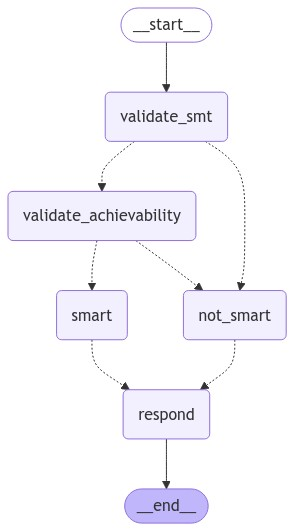

In [324]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [330]:
initial_state = {"query": "Actually, i want to build a restaurant. I estimated the costs they are 700 000$. I struggled to collect 300 000$. And i am willing to invest 1 000$ monthly! I am expecting annual return of 5%"}
result = app.invoke(initial_state)

print("Final result:", result)

check_smt_goal: Current state: {'query': 'Actually, i want to build a restaurant. I estimated the costs they are 700 000$. I struggled to collect 300 000$. And i am willing to invest 1 000$ monthly! I am expecting annual return of 5%'}
is_smt_goal: Current state: {'query': 'Actually, i want to build a restaurant. I estimated the costs they are 700 000$. I struggled to collect 300 000$. And i am willing to invest 1 000$ monthly! I am expecting annual return of 5% \n goal: build a restaurant \n initial_investment: 300000.0 \n\n    monthly_contribution: 1000.0 \n annual_return: 0.05 \n target_value: 700000.0 \n\n    time_horizon: 0 \n is_specific: True \n is_measurable: True \n\n    is_time: False', 'goal': 'build a restaurant', 'initial_investment': 300000.0, 'monthly_contribution': 1000.0, 'annual_return': 0.05, 'target_value': 700000.0, 'time_horizon': 0, 'is_specific': 'True', 'is_measurable': 'True', 'is_time': 'False'}
refused: Current state: {'query': 'Actually, i want to build a r

In [373]:
type(result.get('final_respone'))

str